In [55]:
"""
Title     : Aruba 17 Aktivitätsindex
Author    : Jan-Luca Nettingsmeier, Dimitri Dening
Created   : 21.11.2024
"""

'\nTitle     : Aruba 17 Aktivitätsindex\nAuthor    : Jan-Luca Nettingsmeier, Dimitri Dening\nCreated   : 21.11.2024\n'

In [56]:
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy

### Voranalyse von Rohdaten
- Erkenntnisse
    - In den Tags `meta` und `meta_begin_end` fehlen ~99.2% der Daten
    - `meta` und `meta_begin_end` sind zunächst nicht relevante Daten

+ Weiteres Vorgehen:  
    - Verwende gekürzten Datensatz
    - Entferne nicht relevante Tags/Einträge
    - Analysiere relevante Einträge auf Fehler etc. und betreibe `Data Cleaning`

In [57]:
data_dir = "../data/aruba/data.csv"

df_aruba = pd.read_csv(
    data_dir,
    sep=r"\s+",
    names=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
        "meta",
        "meta_begin_end",
    ],
)

# profile = ProfileReport(df_aruba, title="Profiling Report")
# profile.to_file("aruba17.html")

# df_aruba.info()
# df_aruba.describe()

In [58]:
# Nutze nur relevante Einträge
df_aruba = pd.read_csv(
    data_dir,
    sep=r"\s+",
    names=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
        "meta",
        "meta_begin_end",
    ],
    usecols=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
    ],
)

display(df_aruba)

,date,time,sensor_type,sensor_status
0,2010-11-04,00:03:50.209589,M003,ON
1,2010-11-04,00:03:57.399391,M003,OFF
2,2010-11-04,00:15:08.984841,T002,21.5
3,2010-11-04,00:30:19.185547,T003,21
4,2010-11-04,00:30:19.385336,T004,21
...,...,...,...,...
1719553,2011-06-11,23:42:59.28507,T002,25.5
1719554,2011-06-11,23:48:02.888409,T001,23.5
1719555,2011-06-11,23:48:02.988798,T002,25
1719556,2011-06-11,23:53:06.4292,T002,25.5


#### Data Cleaning
- Filter die Sensortypen und die Sensordaten und entferne bzw. ersetze fehlende/beschädigte Einträge.
- Erzeuge neuen Dateneintrag `datetime` und sortiere diese. Der neue Eintrag kombiniert die Einträge `date` und `time`. Zusätzlich wird das Format `ISO8601` auf alle Einträge angewendet.

In [59]:
# Erstelle eine Liste der einzigartigen Sensoren, sortiert nach der Nummer im Namen (z. B. T001 zuerst)
unique_sensor_type = df_aruba["sensor_type"].unique()
unique_sensor_status = df_aruba["sensor_status"].unique()
print("RAW Data:\n-----------")
print(unique_sensor_type)
print(unique_sensor_status)

unwanted_sensor_type_values = ["LEAVEHOME", "ENTERHOME", "c"]
unwanted_sensor_status_values = ["OFcF", "28.55c", "26cc", "OcFF", "O", "OF"]
df_temp = df_aruba
df_temp = df_temp[~df_temp["sensor_type"].isin(unwanted_sensor_type_values)]
df_temp = df_temp[~df_temp["sensor_status"].isin(unwanted_sensor_status_values)]

pattern_sensor_type_on = r"[ON]{2,}[\w]{1,}"
pattern_sensor_type_off = r"[OFF]{3,}[\w]{1,}"

replacements = {
    pattern_sensor_type_on: "ON",
    pattern_sensor_type_off: "OFF",
    "OPENc": "OPEN",
    "CLOSED": "CLOSE",
}

df_temp["sensor_status"] = df_temp["sensor_status"].replace(replacements, regex=True)
updated_unique_values = df_temp["sensor_status"].unique()

unique_sensor_type = df_temp["sensor_type"].unique()
unique_sensor_status = df_temp["sensor_status"].unique()
print("Cleaned Data:\n-----------")
print(unique_sensor_type)
print(unique_sensor_status)

RAW Data:
-----------
['M003' 'T002' 'T003' 'T004' 'T005' 'T001' 'M002' 'M007' 'M005' 'M004'
 'M006' 'M008' 'M020' 'M010' 'M011' 'M012' 'M013' 'M014' 'M009' 'M018'
 'M019' 'M015' 'M016' 'M017' 'M021' 'M022' 'M023' 'M001' 'M024' 'D002'
 'M031' 'D004' 'M030' 'M029' 'M028' 'D001' 'M026' 'M027' 'M025' 'c'
 'LEAVEHOME' 'ENTERHOME']
['ON' 'OFF' '21.5' '21' '20.5' '20' '19.5' '19' '18.5' '26.5' '23' '22.5'
 '23.5' '22' '24.5' '25' '28' '30.5' '27' '26' '32' '28.5' '27.5' '24'
 '33' '29.5' '29' '34' '30' '34.5' '31.5' '25.5' '35' '36' '36.5' '32.5'
 '37' '33.5' 'OPEN' 'CLOSE' '37.5' '31' '35.5' '38' '38.5' '39' '18'
 '17.5' '17' '39.5' '16.5' '16' 'ONc' 'OFFc' 'OFF5' 'OFcF' 'ON5' 'ON55'
 'OFFcc' 'OFF5cc' 'OFF5c' 'ON5c' '28.55c' 'OFFc5' 'ONcc' 'ONc5c' '26cc'
 '285' 'ONc5' 'OPENc' 'OcFF' 'OFFccc5' '19.55' '245' '225' '23.555' '235'
 '42' 'O' 'OF' 'ONM026' '41.5' '42.5' '43' '40.5' 'ONM009' 'ONM024' '180'
 '300' '6592' 'CLOSED']
Cleaned Data:
-----------
['M003' 'T002' 'T003' 'T004' 'T005' 'T001'

In [60]:
# Konvertiere Datum und Uhrzeit in eine einzige Spalte mit einem Datetime-Objekt
df_temp["datetime"] = pd.to_datetime(df_temp["date"] + " " + df_temp["time"], format="ISO8601")

# Sortiere die Daten nach Datum und Uhrzeit
df_temp = df_temp.sort_values(by="datetime")

display(df_temp)

,date,time,sensor_type,sensor_status,datetime
0,2010-11-04,00:03:50.209589,M003,ON,2010-11-04 00:03:50.209589
1,2010-11-04,00:03:57.399391,M003,OFF,2010-11-04 00:03:57.399391
2,2010-11-04,00:15:08.984841,T002,21.5,2010-11-04 00:15:08.984841
3,2010-11-04,00:30:19.185547,T003,21,2010-11-04 00:30:19.185547
4,2010-11-04,00:30:19.385336,T004,21,2010-11-04 00:30:19.385336
...,...,...,...,...,...
1719553,2011-06-11,23:42:59.28507,T002,25.5,2011-06-11 23:42:59.285070
1719554,2011-06-11,23:48:02.888409,T001,23.5,2011-06-11 23:48:02.888409
1719555,2011-06-11,23:48:02.988798,T002,25,2011-06-11 23:48:02.988798
1719556,2011-06-11,23:53:06.4292,T002,25.5,2011-06-11 23:53:06.429200


In [61]:
df_temp.to_csv("../data/aruba/data_cleaned.csv", index=False)

#### Visualisierung
- Vorgehen/Ziel:
    - Nutze den neuen gesäuberten Datensatz `data_cleaned.csv`
    - Verwende Diagramme etc. um einen Ersteindruck der Daten zu bekommen
    - Betracht Motion-Sensordaten um einen Aktivitätsindex zu berechnen

In [62]:
data_cleaned_dir = "../data/aruba/data_cleaned.csv"

df_aruba = pd.read_csv(
    data_cleaned_dir,
    delimiter=",",
    header=0,
    names=[
        "date",
        "time",
        "sensor_type",
        "sensor_status",
        "datetime",
    ],
)

display(df_aruba)

,date,time,sensor_type,sensor_status,datetime
0,2010-11-04,00:03:50.209589,M003,ON,2010-11-04 00:03:50.209589
1,2010-11-04,00:03:57.399391,M003,OFF,2010-11-04 00:03:57.399391
2,2010-11-04,00:15:08.984841,T002,21.5,2010-11-04 00:15:08.984841
3,2010-11-04,00:30:19.185547,T003,21,2010-11-04 00:30:19.185547
4,2010-11-04,00:30:19.385336,T004,21,2010-11-04 00:30:19.385336
...,...,...,...,...,...
1719539,2011-06-11,23:42:59.28507,T002,25.5,2011-06-11 23:42:59.285070
1719540,2011-06-11,23:48:02.888409,T001,23.5,2011-06-11 23:48:02.888409
1719541,2011-06-11,23:48:02.988798,T002,25,2011-06-11 23:48:02.988798
1719542,2011-06-11,23:53:06.4292,T002,25.5,2011-06-11 23:53:06.429200


Hilfsfunktionen um "saubere" Datensätze zu erzeugen

In [63]:
def create_data_subset(df: pd.DataFrame, pattern: str) -> pd.DataFrame:
    df_subset = df[df["sensor_type"].str.match(pattern)]
    df_subset.loc[:, "date"] = pd.to_datetime(df_subset["date"])
    df_subset.loc[:, "datetime"] = pd.to_datetime(df_subset["datetime"])
    return df_subset

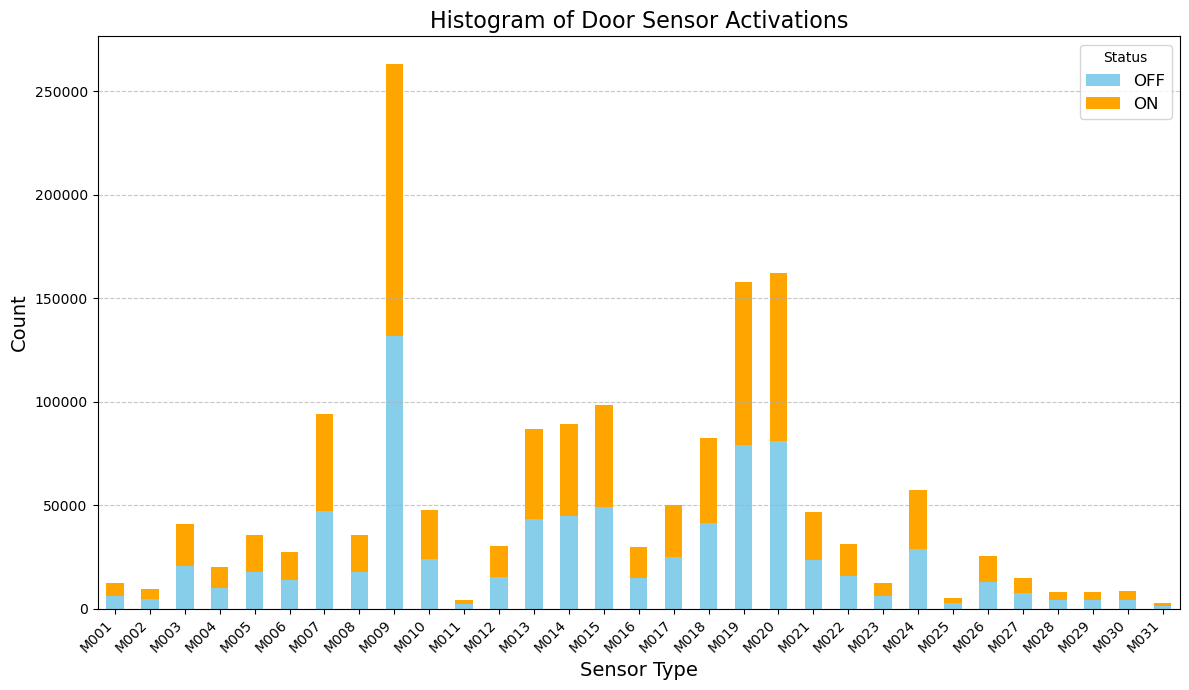

In [64]:
# Regex pattern for motion sensors (e.g., M001, M002, etc.)
pattern_motion_sensor = r"[M]{1}[0-9]{3,}"

# Create a subset for motion sensors
df_motion_sensor = df_aruba[df_aruba["sensor_type"].str.match(pattern_motion_sensor)]

# Use pivot_table to count ON/OFF occurrences for each sensor
motion_sensor_status_counts = df_motion_sensor.pivot_table(
    index="sensor_type",
    columns="sensor_status",
    aggfunc="size",
    fill_value=0,  # Replace missing values with 0
)

# Plot the grouped data
motion_sensor_status_counts.plot(
    kind="bar",
    figsize=(12, 7),
    stacked=True,  # Stacked bar chart to show ON/OFF counts together
    color=["skyblue", "orange"],  # Colors for ON and OFF
)

# Add titles and labels
plt.title("Histogram of Door Sensor Activations", fontsize=16)
plt.xlabel("Sensor Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Status", labels=motion_sensor_status_counts.columns, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

## Berechnung des Aktivitätsindex

Der **Aktivitätsindex** beschreibt die Zeit, in der ein Sensor aktiv war (ON-Status), relativ zur Gesamtzeit eines definierten Zeitraums. Die Berechnung erfolgt in mehreren Schritten:

---

### 1. Datenstruktur verstehen
- **Zeitstempel**: Gibt den Zeitpunkt der Statusänderung (ON oder OFF) an.
- **Sensor-ID**: Z. B. „M003“ (es könnten mehrere Sensoren existieren).
- **Status**: ON (aktiv) oder OFF (inaktiv).

---

### 2. Aktivitätszeit berechnen
Für jeden Zeitraum zwischen einem **ON**- und einem **OFF**-Ereignis wird die Aktivitätsdauer berechnet:

$$
\text{Dauer} = \text{Zeitstempel}_{\text{OFF}} - \text{Zeitstempel}_{\text{ON}}
$$

#### Beispiel:
- **ON**: `2010-11-04 02:32:33.351906`  
- **OFF**: `2010-11-04 02:32:38.895958`

$$
\text{Dauer} = \text{2010-11-04 02:32:38.895958} - \text{2010-11-04 02:32:33.351906} = 5{,}544 \, \text{Sekunden}
$$

---

### 3. Gesamtzeit definieren
Definiere einen **Analysezeitraum** (z. B. pro Minute, Stunde oder Tag). In diesem Zeitraum wird die **Gesamtzeit** $T_{\text{gesamt}}$ berechnet.

---

### 4. Berechnung des Aktivitätsindex
Der Aktivitätsindex wird als Verhältnis der Zeit, in der der Sensor aktiv war, zur Gesamtzeit berechnet:

$$
\text{Aktivitätsindex} = \frac{\text{Gesamtaktivitätszeit}}{\text{Gesamtzeit}} \cdot 100
$$

#### Beispiel:
- **Analysezeitraum**: 1 Minute ($ T_{\text{gesamt}} = 60 \, \text{Sekunden} $)  
- **Sensoraktivitätszeit**: $ 5{,}544 \, \text{Sekunden} $

$$
\text{Aktivitätsindex} = \frac{5{,}544}{60} \cdot 100 = 9{,}24 \, \%
$$

---

### 5. Zusammenfassung
Für einen Sensor $ M $:
1. Addiere alle Aktivitätsdauern ( $T_{\text{aktiv}} $) im Analysezeitraum.
2. Teile $ T_{\text{aktiv}} $ durch $ T_{\text{gesamt}} $, um den Aktivitätsindex zu berechnen.

---

### 6. Erweiterung bei mehreren Sensoren
Falls mehrere Sensoren (z. B. M001, M002, ...) vorliegen:
- Berechne den Aktivitätsindex für jeden Sensor separat.
- Der **Gesamtaktivitätsindex** kann als Durchschnitt oder Summe der Aktivitätsindizes aller Sensoren berechnet werden:

$$
\text{Gesamtaktivitätsindex} = \frac{\sum_{i=1}^N \text{Aktivitätsindex}_i}{N}
$$


In [65]:
def plot_activity(df_motion_sensor: pd.DataFrame, start_date: str, end_date: str) -> None:
    start_datetime = start_date  # "2010-11-08 02:00:00"
    end_datetime = end_date  # "2010-11-12 02:00:00"

    # Liste von Sensoren, für die der Aktivitätsindex berechnet werden soll (z. B. M001, M002)
    selected_sensors = []  # ["M001", "M003"]

    # Umwandeln der Zeitstempel in datetime-Objekte
    start_datetime = pd.to_datetime(start_datetime)
    end_datetime = pd.to_datetime(end_datetime)

    # Umwandeln der Datums- und Zeitspalten in einen Datetime-Typ
    df_motion_sensor = df_motion_sensor.copy()
    df_motion_sensor["datetime"] = pd.to_datetime(df_motion_sensor["datetime"])

    # Nur Zeilen mit 'ON' und 'OFF' Status
    df_motion_sensor_on_off = df_motion_sensor[df_motion_sensor["sensor_status"].isin(["ON", "OFF"])]

    # Filtere die Daten basierend auf dem angegebenen Zeitraum
    df_motion_sensor_on_off = df_motion_sensor_on_off[
        (df_motion_sensor_on_off["datetime"] >= start_datetime) & (df_motion_sensor_on_off["datetime"] <= end_datetime)
    ]

    # Sortieren nach Zeitstempel, falls noch nicht sortiert
    df_motion_sensor_on_off = df_motion_sensor_on_off.sort_values(by="datetime")

    # Filtere nur die gewünschten Sensoren
    if len(selected_sensors) != 0:
        df_motion_sensor_on_off = df_motion_sensor_on_off[
            df_motion_sensor_on_off["sensor_type"].isin(selected_sensors)
        ]

    # Liste der einzigartigen Sensoren
    unique_sensor_type = df_motion_sensor_on_off["sensor_type"].unique()
    unique_sensor_type = sorted(unique_sensor_type, key=lambda x: int(x[1:]))

    # Dictionary zum Speichern der Aktivitätsindizes für jeden Sensor
    activity_indices = {}

    # Berechnung des Aktivitätsindex für jeden Sensor
    for sensor in unique_sensor_type:
        # Filtere nur die Daten für den aktuellen Sensor
        df_sensor = df_motion_sensor_on_off[df_motion_sensor_on_off["sensor_type"] == sensor]

        # Berechnung der aktiven Zeiten (Dauer zwischen ON und OFF)
        active_times = []

        for i in range(1, len(df_sensor)):
            # Finde Paare von ON und OFF
            if df_sensor.iloc[i - 1]["sensor_status"] == "ON" and df_sensor.iloc[i]["sensor_status"] == "OFF":
                start_time = df_sensor.iloc[i - 1]["datetime"]
                end_time = df_sensor.iloc[i]["datetime"]
                active_duration = (end_time - start_time).total_seconds()  # Dauer in Sekunden
                active_times.append(active_duration)

        # Gesamtaktive Zeit
        total_active_time = np.sum(active_times)

        # Gesamtzeit des analysierten Zeitraums (vom ersten bis zum letzten Timestamp des Sensors)
        start_time_period = df_sensor["datetime"].min()
        end_time_period = df_sensor["datetime"].max()
        total_time_period = (end_time_period - start_time_period).total_seconds()

        # Berechnung des Aktivitätsindex für den Sensor
        activity_index = (total_active_time / total_time_period) * 100

        # Speichern des Aktivitätsindex im Dictionary
        activity_indices[sensor] = activity_index

    # Ausgabe der Aktivitätsindizes für alle Sensoren
    # for sensor, index in activity_indices.items():
    #     print(f"Sensor {sensor}: Aktivitätsindex = {index:.2f}%")

    # Daten in einem DataFrame
    activity_index = [sensor_activity[1] for sensor_activity in activity_indices.items()]
    data = {"Sensor": unique_sensor_type, "Aktivitätsindex": activity_index}
    df_activity = pd.DataFrame(data)

    # Balkendiagramm erstellen
    plt.figure(figsize=(14, 7))
    sns.barplot(x="Sensor", y="Aktivitätsindex", data=df_activity, palette="Blues_d", hue="Sensor", legend=False)

    # Diagramm formatieren
    plt.title(
        "Aktivitätsindex der Sensoren ({s1} - {e1}) ({s2} - {e2})".format(
            s1=start_datetime.day_name(), e1=end_datetime.day_name(), s2=start_datetime, e2=end_datetime
        ),
        fontsize=16,
    )
    plt.xlabel("Sensoren", fontsize=14)
    plt.ylabel("Aktivitätsindex (%)", fontsize=14)

    # Dynamisches Setzen der Y-Achse basierend auf dem maximalen Aktivitätsindex
    max_value = df_activity["Aktivitätsindex"].max()
    plt.ylim(0, max_value + (0.1 * max_value))  # Setzt das obere Limit auf 10% mehr als der Maximalwert

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

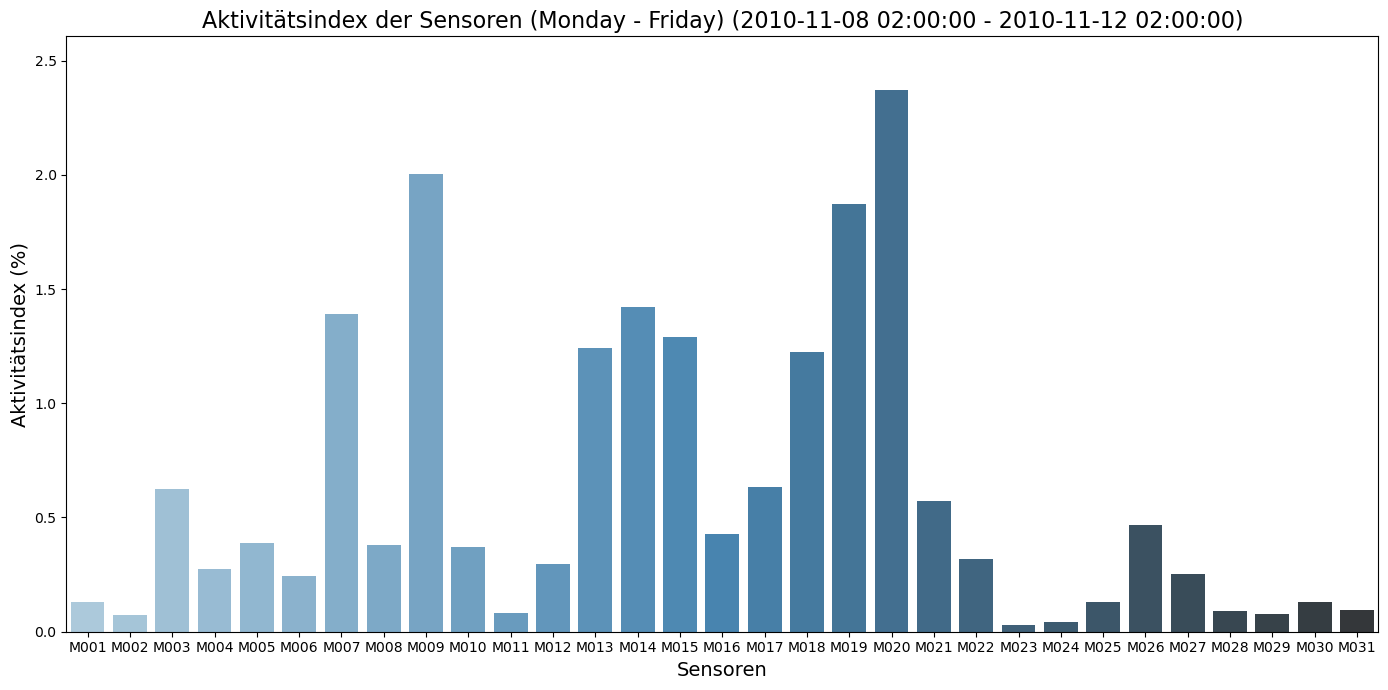

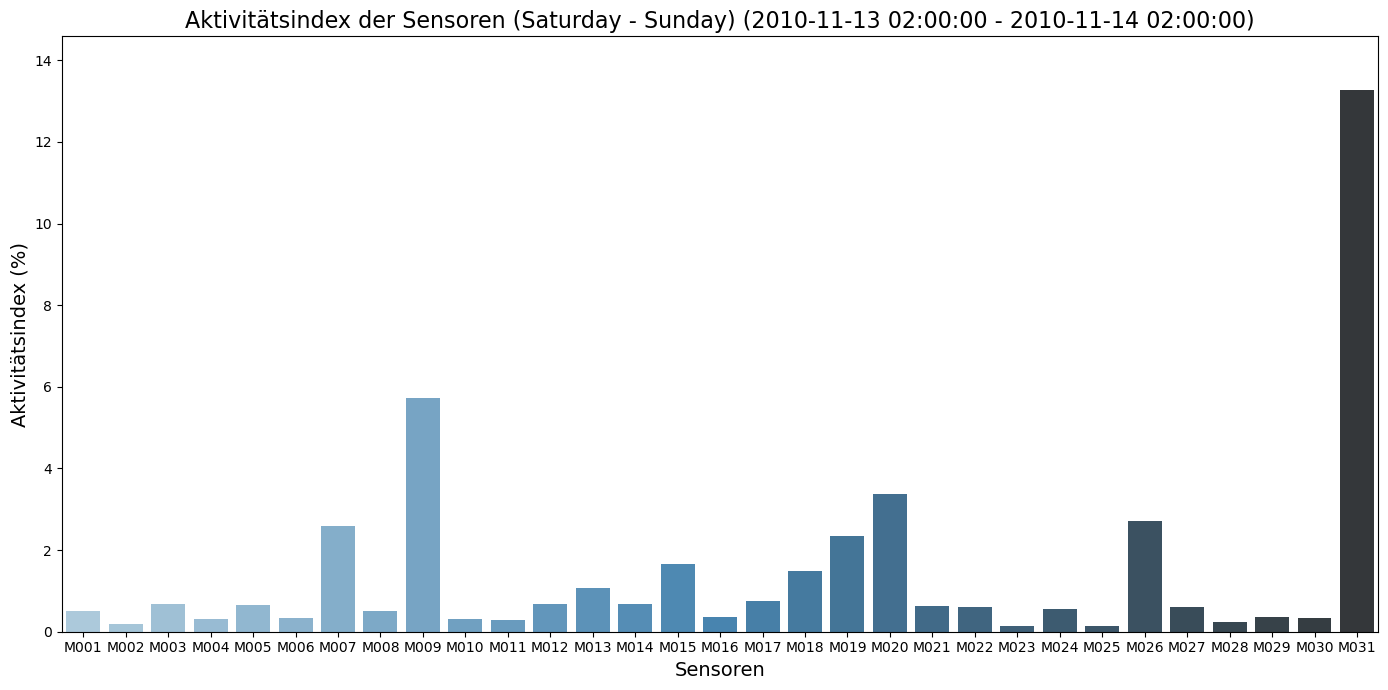

In [66]:
# Beispiel: Definiere den Zeitraum (Start- und Endzeit als Strings im Format 'YYYY-MM-DD HH:MM:SS')
start_datetime = "2010-11-08 02:00:00"
end_datetime = "2010-11-12 02:00:00"
plot_activity(df_motion_sensor, start_datetime, end_datetime)

start_datetime = "2010-11-13 02:00:00"
end_datetime = "2010-11-14 02:00:00"
plot_activity(df_motion_sensor, start_datetime, end_datetime)

#### Schlafanalyse

In [67]:
# Create a subset for motion sensors
df_motion_sensor = create_data_subset(df_aruba, pattern_motion_sensor)
df_motion_sensor = df_motion_sensor.reset_index(drop=True)

generate_sensor_list = lambda n: [f"M{str(i).zfill(3)}" for i in range(1, n + 1)]
motion_sensor_list = generate_sensor_list(31)

filter_sensor_location = {
    "all": motion_sensor_list,
    "bedroom_main": ["M001", "M002", "M003", "M004", "M005", "M006", "M007"],
}

df_motion_sensor = df_motion_sensor.loc[df_motion_sensor["sensor_type"].isin(filter_sensor_location["bedroom_main"])]

print(df_motion_sensor.info())
display(df_motion_sensor)

<class 'pandas.core.frame.DataFrame'>
Index: 239502 entries, 0 to 1596137
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   date           239502 non-null  object
 1   time           239502 non-null  object
 2   sensor_type    239502 non-null  object
 3   sensor_status  239502 non-null  object
 4   datetime       239502 non-null  object
dtypes: object(5)
memory usage: 11.0+ MB
None


,date,time,sensor_type,sensor_status,datetime
0,2010-11-04 00:00:00,00:03:50.209589,M003,ON,2010-11-04 00:03:50.209589
1,2010-11-04 00:00:00,00:03:57.399391,M003,OFF,2010-11-04 00:03:57.399391
2,2010-11-04 00:00:00,02:32:33.351906,M003,ON,2010-11-04 02:32:33.351906
3,2010-11-04 00:00:00,02:32:38.895958,M003,OFF,2010-11-04 02:32:38.895958
4,2010-11-04 00:00:00,03:42:21.82365,M003,ON,2010-11-04 03:42:21.823650
...,...,...,...,...,...
1596133,2011-06-11 00:00:00,22:33:01.209214,M002,ON,2011-06-11 22:33:01.209214
1596134,2011-06-11 00:00:00,22:33:02.952009,M003,OFF,2011-06-11 22:33:02.952009
1596135,2011-06-11 00:00:00,22:33:03.332876,M002,OFF,2011-06-11 22:33:03.332876
1596136,2011-06-11 00:00:00,23:20:31.432636,M003,ON,2011-06-11 23:20:31.432636


In [68]:
period = "30min"

df_activity = pd.DataFrame()

df_activity["activity"] = (
    df_motion_sensor.loc[df_motion_sensor["sensor_status"] == "ON"]
    .resample(period, on="datetime")["sensor_status"]
    .count()
)

df_activity["activity_per_sensor"] = (
    df_motion_sensor.loc[df_motion_sensor["sensor_status"] == "ON"]
    .resample(period, on="datetime")
    .apply(lambda group: group.groupby("sensor_type").size().to_dict())
)

df_activity["datetime"] = df_activity.index

df_activity = df_activity.reset_index(drop=True)
df_activity["date"] = df_activity["datetime"].dt.date
df_activity["time"] = df_activity["datetime"].dt.time

# List of weekday names
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_activity["weekday"] = df_activity["date"].apply(lambda d: days[d.weekday()])

df_activity

/opt/conda/lib/python3.12/site-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)
/opt/conda/lib/python3.12/site-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


,activity,activity_per_sensor,datetime,date,time,weekday
0,1,{'M003': 1},2010-11-04 00:00:00,2010-11-04,00:00:00,Thursday
1,0,{},2010-11-04 00:30:00,2010-11-04,00:30:00,Thursday
2,0,{},2010-11-04 01:00:00,2010-11-04,01:00:00,Thursday
3,0,{},2010-11-04 01:30:00,2010-11-04,01:30:00,Thursday
4,0,{},2010-11-04 02:00:00,2010-11-04,02:00:00,Thursday
...,...,...,...,...,...,...
10554,0,{},2011-06-11 21:00:00,2011-06-11,21:00:00,Saturday
10555,0,{},2011-06-11 21:30:00,2011-06-11,21:30:00,Saturday
10556,38,"{'M002': 12, 'M003': 6, 'M004': 2, 'M005': 2, ...",2011-06-11 22:00:00,2011-06-11,22:00:00,Saturday
10557,4,"{'M002': 2, 'M003': 2}",2011-06-11 22:30:00,2011-06-11,22:30:00,Saturday


In [69]:
filter_days = {
    "all": [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    "in_the_week": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"],
    "weekend": ["Saturday", "Sunday"],
    "mondays": ["Monday"],
    "tuesdays": ["Tuesday"],
    "wednesdays": ["Wednesday"],
    "thursdays": ["Thursday"],
    "fridays": ["Friday"],
    "saturdays": ["Saturday"],
    "sundays": ["Sunday"],
}

df_activity = df_activity.loc[df_activity["weekday"].isin(filter_days["all"])]

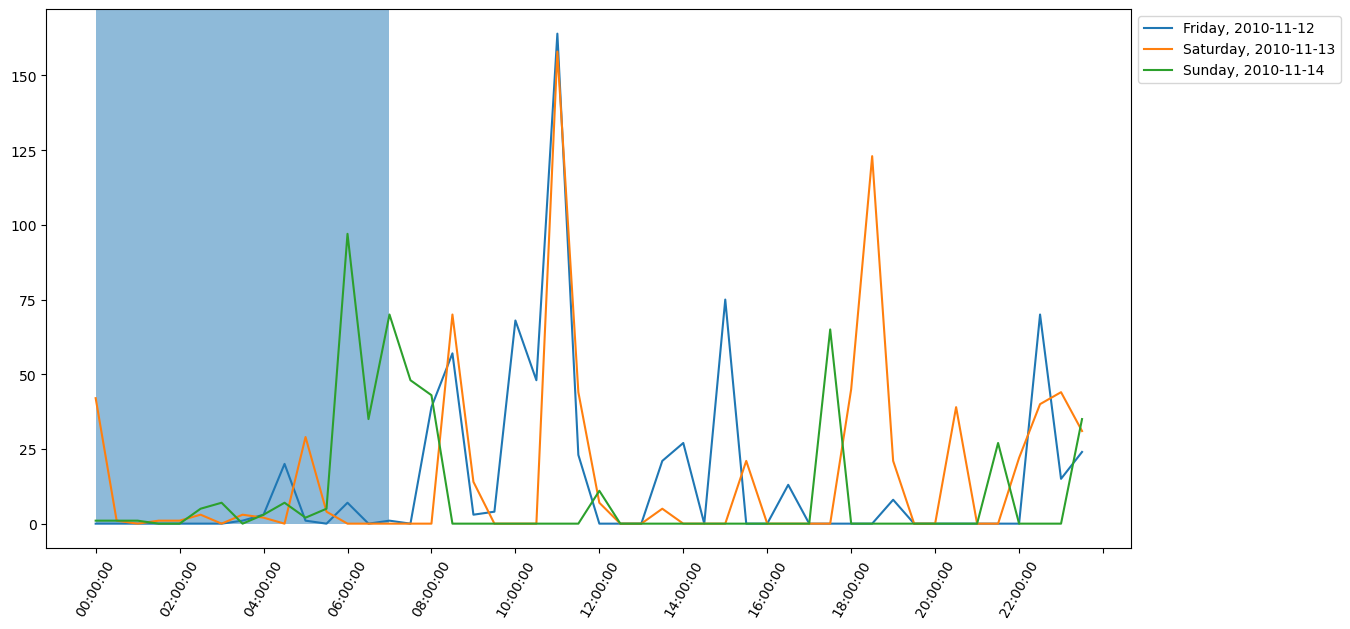

In [70]:
date_from = pd.to_datetime("2010-11-12").date()
date_to = pd.to_datetime("2010-11-14").date()

unique_dates = df_activity["date"].unique()

plt.figure(figsize=(14, 7))
ax = plt.axes()

# plot box for night
night_box = Rectangle((0, 0), 14, 2000)
pc = PatchCollection([night_box], alpha=0.5)
ax.add_collection(pc)

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
plt.xticks(rotation=60)

for date in unique_dates:
    if (date < date_from) | (date > date_to):
        continue

    df_activity_day = df_activity.loc[(df_activity["date"] == date)]
    plt.plot(
        df_activity_day["time"].apply(lambda time: time.strftime("%H:%M:%S")),
        df_activity_day["activity"],
        label=df_activity_day["weekday"].unique()[0] + ", " + date.strftime("%Y-%m-%d"),
    )

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

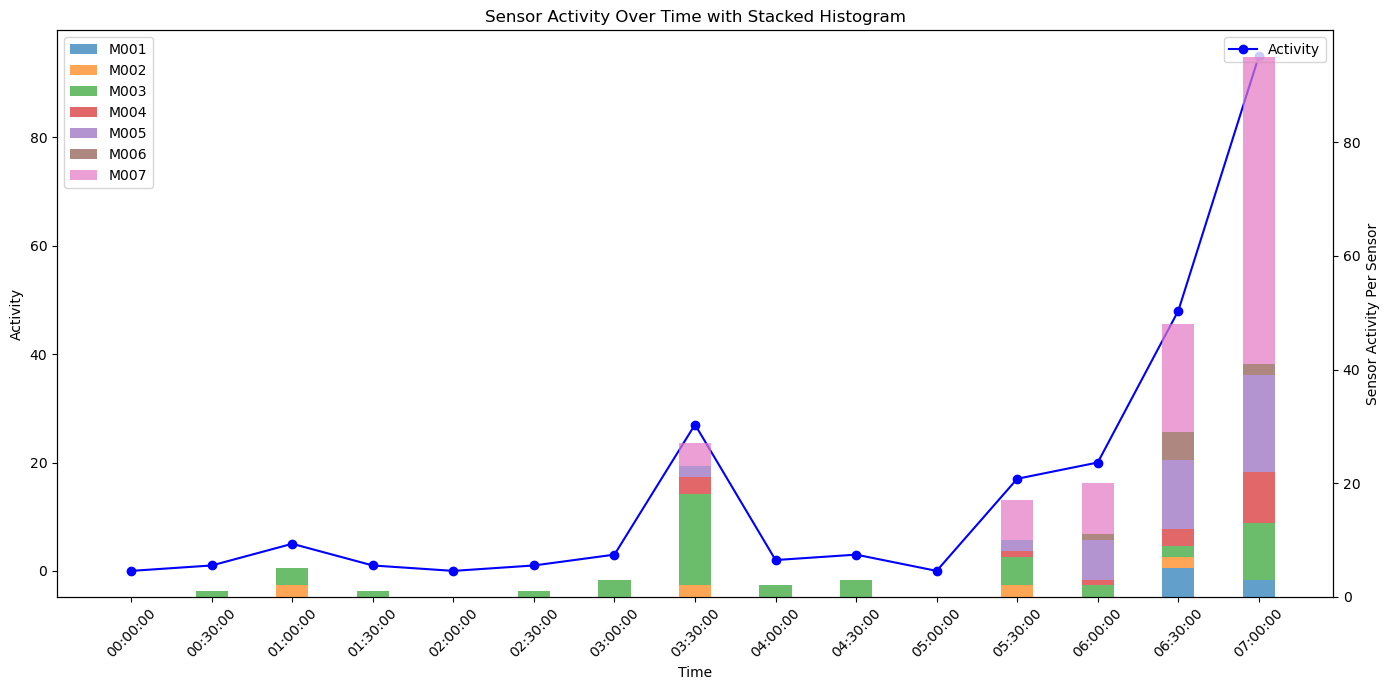

In [71]:
# TODO: Only works for one day period ..

# Define the date and time ranges
date_from = pd.to_datetime("2010-12-12").date()
date_to = pd.to_datetime("2010-12-12").date()
time_from = pd.to_datetime("00:00:00").time()
time_to = pd.to_datetime("07:00:59").time()

# Filter data for the specified range
df_filtered = df_activity.loc[
    (df_activity["date"] >= date_from)
    & (df_activity["date"] <= date_to)
    & (df_activity["time"] >= time_from)
    & (df_activity["time"] <= time_to)
]

# Extract unique time points for x-axis
time_points = df_filtered["time"].apply(lambda t: t.strftime("%H:%M:%S")).tolist()

# Prepare histogram data
sensor_columns = set()
for sensors in df_filtered["activity_per_sensor"]:
    sensor_columns.update(sensors.keys())
sensor_columns = sorted(sensor_columns)

# Create a DataFrame for stacked histogram
sensor_data = pd.DataFrame(0, index=df_filtered.index, columns=sensor_columns)
for idx, sensors in df_filtered["activity_per_sensor"].items():
    for sensor, count in sensors.items():
        sensor_data.loc[idx, sensor] = count

# Create the plot
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the time-series data
ax1.plot(
    time_points,
    df_filtered["activity"],
    label="Activity",
    color="blue",
    marker="o",
)

# Plot the stacked histogram
bottom = np.zeros(len(sensor_data))
bar_width = 0.4
x_positions = np.arange(len(sensor_data))

for sensor in sensor_columns:
    ax2.bar(
        x_positions,
        sensor_data[sensor],
        bottom=bottom,
        label=sensor,
        width=bar_width,
        alpha=0.7,
    )
    bottom += sensor_data[sensor]

# Customize axes
ax1.set_xlabel("Time")
ax1.set_ylabel("Activity")
ax2.set_ylabel("Sensor Activity Per Sensor")
ax1.set_xticks(x_positions)
ax1.set_xticklabels(time_points, rotation=45)
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

# Title and layout adjustments
plt.title("Sensor Activity Over Time with Stacked Histogram")
plt.tight_layout()
plt.show()